<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/GenerativeModelDemo/blob/modify/PresentationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

## Preprocessing

In [2]:
import torch
from diffusers import StableDiffusionAdapterPipeline, T2IAdapter
import os
import kagglehub
import shutil
import pandas as pd
import numpy as np
from PIL import Image
from datasets import Dataset

In [3]:
!pwd

/content


In [4]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("adityajn105/flickr8k")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

Download Dataset Already


In [5]:
df = pd.read_csv("./dataset/captions.txt")
df.rename(columns={'image':"filename"}, inplace=True)
df.loc[:100]

filename  \
0    1000268201_693b08cb0e.jpg   
1    1000268201_693b08cb0e.jpg   
2    1000268201_693b08cb0e.jpg   
3    1000268201_693b08cb0e.jpg   
4    1000268201_693b08cb0e.jpg   
..                         ...   
96    102351840_323e3de834.jpg   
97    102351840_323e3de834.jpg   
98    102351840_323e3de834.jpg   
99    102351840_323e3de834.jpg   
100  1024138940_f1fefbdce1.jpg   

                                               caption  
0    A child in a pink dress is climbing up a set o...  
1                A girl going into a wooden building .  
2     A little girl climbing into a wooden playhouse .  
3    A little girl climbing the stairs to her playh...  
4    A little girl in a pink dress going into a woo...  
..                                                 ...  
96   A man is drilling through the frozen ice of a ...  
97   A person in the snow drilling a hole in the ice .  
98                A person standing on a frozen lake .  
99                           Two men are ice fishing .  
100  Two different breeds of brown and white dogs p...  

[101 rows x 2 columns]

In [6]:
df["caption"].tolist()

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .',
 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails pain

In [7]:
def load_image(example):
    image_path = os.path.join("./dataset/Images", example["filename"])
    image = Image.open(image_path).convert("RGB")
    image = image.resize((256, 256)) # !!!
    example['images'] = image
    conditioning_image = image.resize((8, 8))
    conditioning_image = conditioning_image.resize((256, 256), resample=Image.Resampling.NEAREST) # !!!!
    example['conditioning_images'] = conditioning_image

    return example

dataset = Dataset.from_pandas(df.loc[:100])
dataset = dataset.map(load_image)
dataset[0]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

{'filename': '1000268201_693b08cb0e.jpg',
 'caption': 'A child in a pink dress is climbing up a set of stairs in an entry way .',
 'images': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'conditioning_images': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>}

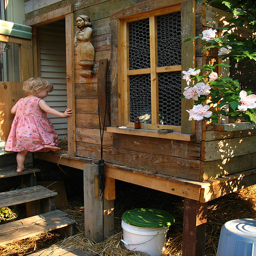

In [8]:
dataset[0]['images']

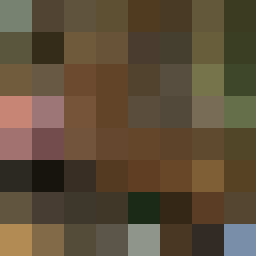

In [9]:
dataset[0]["conditioning_images"]

In [10]:
dataset[0]

{'filename': '1000268201_693b08cb0e.jpg',
 'caption': 'A child in a pink dress is climbing up a set of stairs in an entry way .',
 'images': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'conditioning_images': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>}

## Train Model

In [11]:
adapter = T2IAdapter.from_pretrained("TencentARC/t2iadapter_color_sd14v1", torch_dtype=torch.float16)
pipe = StableDiffusionAdapterPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    adapter=adapter,
    torch_dtype=torch.float16,
)
pipe.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
An error occurred while trying to fetch TencentARC/t2iadapter_color_sd14v1: TencentARC/t2iadapter_color_sd14v1 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionAdapterPipeline {
  "_class_name": "StableDiffusionAdapterPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "adapter": [
    "diffusers",
    "T2IAdapter"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Generate Image before train

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/t2i_adapter/pipeline_stable_diffusion_adapter.py:500: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


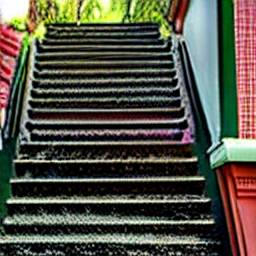

In [12]:
generator = torch.manual_seed(0)

out_image = pipe(
    "A child in a pink dress is climbing up a set of stairs in an entry way .",
    image=dataset[0]["conditioning_images"],
    generator=generator,
).images[0]
out_image

In [13]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms

# DataLoader function
def collate_fn(batch):
    images = [example["images"] for example in batch]
    conditions = [example["conditioning_images"] for example in batch]
    texts = [example["caption"] for example in batch]
    return images, conditions, texts

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Define optimizer
optimizer = torch.optim.Adam(pipe.adapter.parameters(), lr=1e-4)

# Convert Image to pytorch tensor and move to GPU
transform = transforms.Compose([
    transforms.PILToTensor()
])

In [14]:
images, conditioning_images, texts = next(iter(dataloader))
images = [transform(img) for img in images]
images = torch.stack(images)
images.shape

torch.Size([4, 3, 256, 256])

In [15]:
# Training loop
for epoch in range(10):  # Number of epochs
    for images, conditioning_images, texts in dataloader:
        optimizer.zero_grad()

        # Move to GPU
        images = [transform(img).type(torch.float16) for img in images]
        images = torch.stack(images)
        images = images.to("cuda")

        conditioning_images = [transform(cond).type(torch.float16) for cond in conditioning_images]
        conditioning_images = torch.stack(conditioning_images)
        conditioning_images = conditioning_images.to("cuda")

        # Generate latents
        latents = pipe.vae.encode(images).latent_dist.sample()
        latents = latents * 0.18215  # Scale latents

        # Generate conditioning latents
        cond_latents = pipe.vae.encode(conditioning_images).latent_dist.sample()
        cond_latents = cond_latents * 0.18215

        # Text
        input_ids = pipe.tokenizer(
            texts, padding=True, truncation=True, return_tensors="pt"
        ).input_ids.to("cuda")
        encoder_hidden_states = pipe.text_encoder(input_ids).last_hidden_state.to("cuda")

        # Compute loss (MSE loss)
        noise = torch.randn_like(latents)
        noisy_latents = latents + noise

        timestep = torch.randint(1, 1000, (1,), device=pipe.device).type(torch.float16)

        predicted_noise = pipe.unet(noisy_latents, timestep, encoder_hidden_states, cond_latents).sample
        loss = F.mse_loss(predicted_noise, noise)

        # Backpropagation
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item()}")

Epoch 1 Loss: 0.20947265625
Epoch 2 Loss: 0.154296875
Epoch 3 Loss: 0.139404296875
Epoch 4 Loss: 0.14501953125
Epoch 5 Loss: 0.1346435546875
Epoch 6 Loss: 0.2113037109375
Epoch 7 Loss: 0.08953857421875
Epoch 8 Loss: 0.14501953125
Epoch 9 Loss: 0.0673828125
Epoch 10 Loss: 0.10943603515625


## Generative

แก้ error โดยการ reshape encoder_hidden_states

In [16]:
print("Encoder hidden states shape:", encoder_hidden_states.shape)

# ถ้าขนาดไม่ถูกต้อง ให้ reshape ใหม่
if encoder_hidden_states.shape[1] != 77:
    print("Reshaping encoder_hidden_states...")
    encoder_hidden_states = torch.nn.functional.interpolate(
        encoder_hidden_states.permute(0, 2, 1), size=(77,), mode="nearest"
    ).permute(0, 2, 1)

print("New Encoder hidden states shape:", encoder_hidden_states.shape)


Encoder hidden states shape: torch.Size([1, 18, 768])
Reshaping encoder_hidden_states...
New Encoder hidden states shape: torch.Size([1, 77, 768])


gen แบบเลือก input

In [17]:
from PIL import Image

conditioning_img = dataset[0]["conditioning_images"]
conditioning_img = conditioning_img.resize((256, 256))  # ปรับขนาด

generator = torch.manual_seed(0)

out_image = pipe(
    prompt="A child in a pink dress is climbing up a set of stairs in an entry way.",
    image=conditioning_img,
    generator=generator,
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

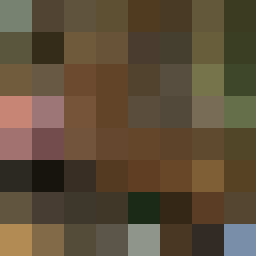

In [18]:
display(conditioning_img)

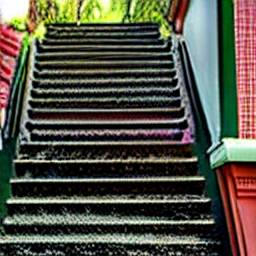

In [19]:
display(out_image)

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


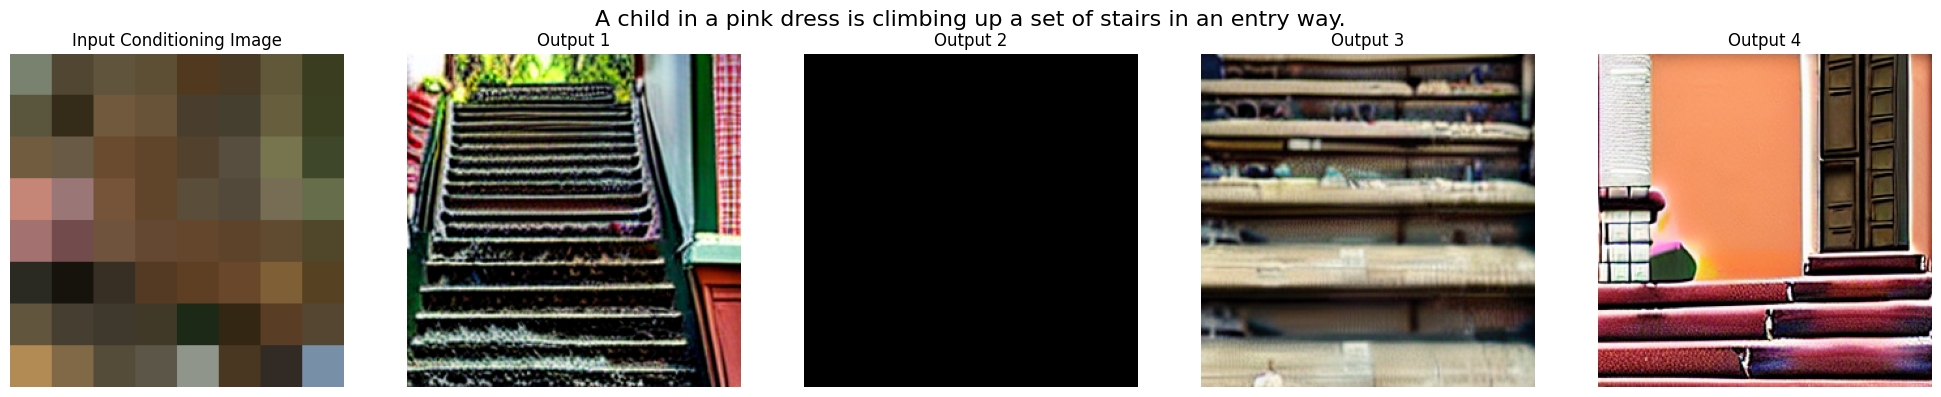

In [20]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

conditioning_img = dataset[0]["conditioning_images"]
conditioning_img = conditioning_img.resize((256, 256))  # ปรับขนาด

prompt = "A child in a pink dress is climbing up a set of stairs in an entry way."

generator = torch.manual_seed(0)

result = pipe(
    prompt=prompt,
    image=conditioning_img,
    generator=generator,
    num_images_per_prompt=4
)

output_images = result.images

num_outputs = len(output_images)
fig, axs = plt.subplots(1, num_outputs + 1, figsize=(4 * (num_outputs + 1), 4))

axs[0].imshow(conditioning_img)
axs[0].set_title("Input Conditioning Image")
axs[0].axis("off")

for i, img in enumerate(output_images):
    axs[i+1].imshow(img)
    axs[i+1].set_title(f"Output {i+1}")
    axs[i+1].axis("off")

plt.suptitle(prompt, fontsize=16)
plt.tight_layout()
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

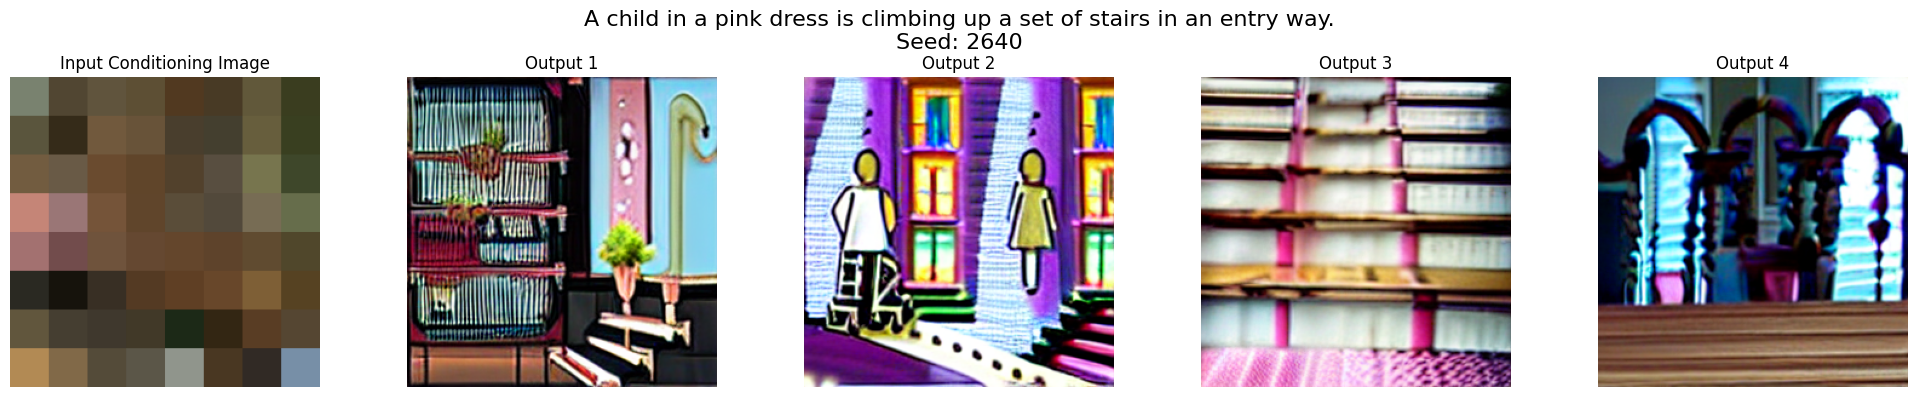

In [21]:
import torch
import random
from PIL import Image
import matplotlib.pyplot as plt
import time


conditioning_img = dataset[0]["conditioning_images"]
conditioning_img = conditioning_img.resize((256, 256))

prompt = "A child in a pink dress is climbing up a set of stairs in an entry way."

while True:
    random_seed = random.randint(0, 100000)
    generator = torch.manual_seed(random_seed)

    # สร้าง output
    result = pipe(
        prompt=prompt,
        image=conditioning_img,  # ส่งรูป conditioning แบบ raw
        generator=generator,
        num_images_per_prompt=4
    )
    output_images = result.images

    # แสดงผล
    num_outputs = len(output_images)
    fig, axs = plt.subplots(1, num_outputs + 1, figsize=(4 * (num_outputs + 1), 4))

    # แสดง input image
    axs[0].imshow(conditioning_img)
    axs[0].set_title("Input Conditioning Image")
    axs[0].axis("off")

    # แสดง output images
    for i, img in enumerate(output_images):
        axs[i+1].imshow(img)
        axs[i+1].set_title(f"Output {i+1}")
        axs[i+1].axis("off")

    plt.suptitle(f"{prompt}\nSeed: {random_seed}", fontsize=16)
    plt.tight_layout()
    plt.show()

    time.sleep(3)
    plt.close('all')

    break

gen แบบสุ่ม input

  0%|          | 0/50 [00:00<?, ?it/s]

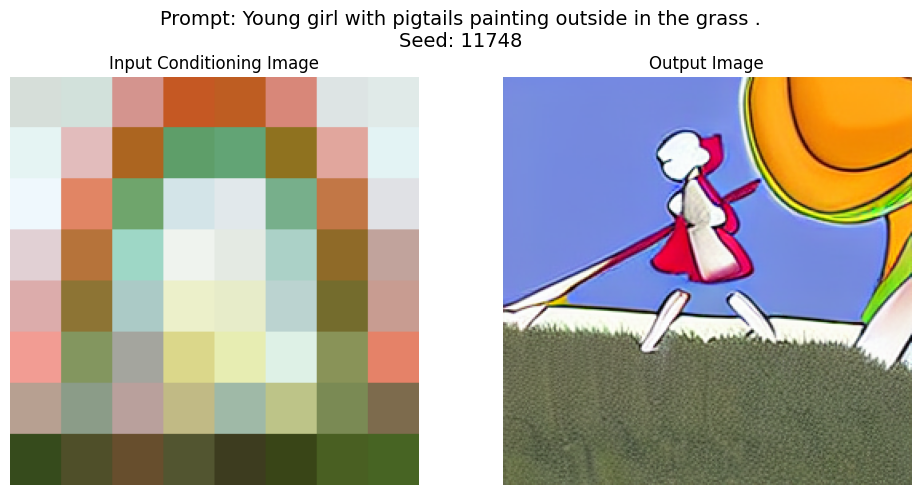

In [22]:
import random
import matplotlib.pyplot as plt
from IPython.display import display

while True:
    idx = random.randint(0, len(dataset)-1)
    sample = dataset[idx]

    conditioning_image = sample["conditioning_images"]
    prompt = sample["caption"]

    random_seed = random.randint(0, 100000)
    generator = torch.manual_seed(random_seed)

    # เรียก pipeline เพื่อ generate output image
    result = pipe(
        prompt=prompt,
        image=conditioning_image,
        generator=generator,
        num_images_per_prompt=1
    )
    out_image = result.images[0]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(conditioning_image)
    axs[0].set_title("Input Conditioning Image")
    axs[0].axis("off")

    axs[1].imshow(out_image)
    axs[1].set_title("Output Image")
    axs[1].axis("off")

    plt.suptitle(f"Prompt: {prompt}\nSeed: {random_seed}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # ถ้าต้องการสุ่มต่อเนื่อง ให้ comment out บรรทัด break
    break


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

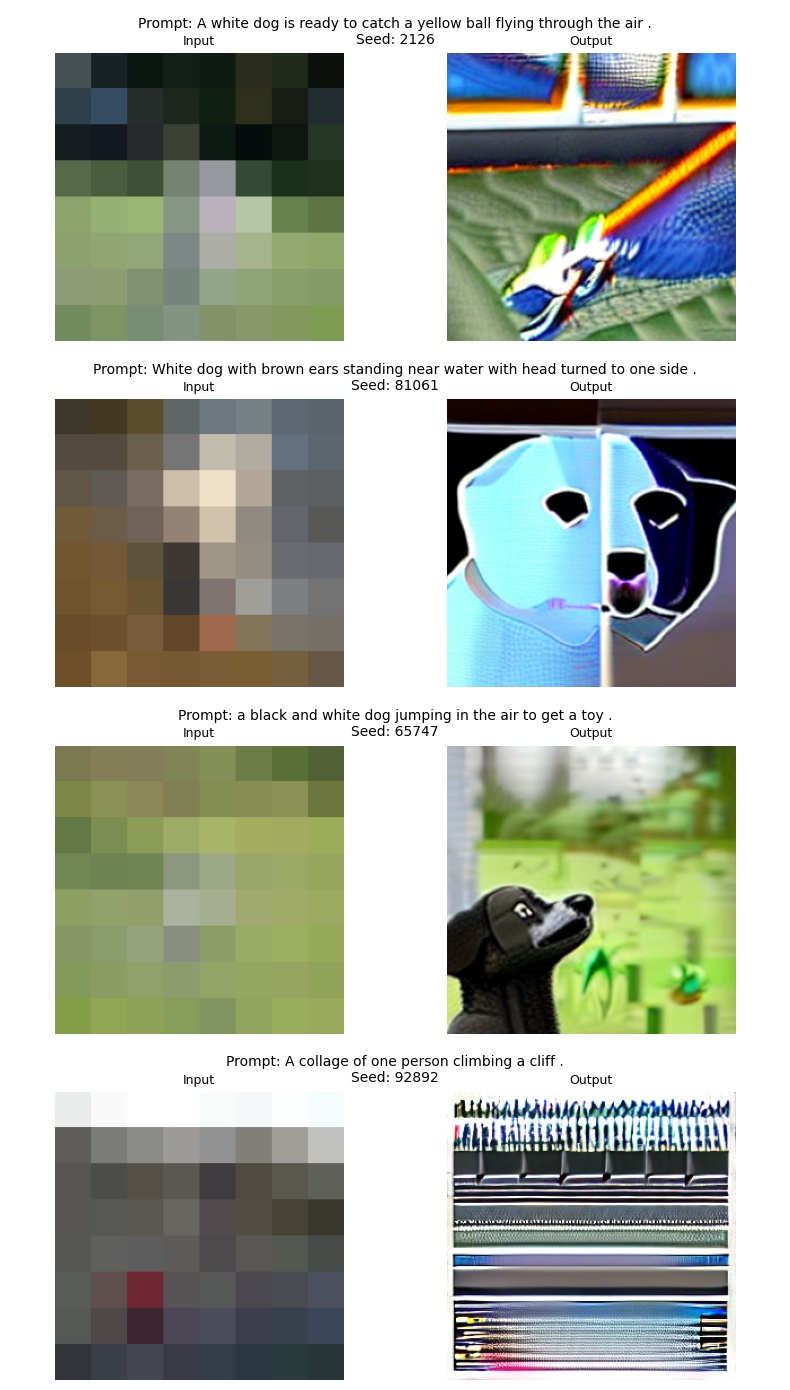

In [23]:
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch

# กำหนดจำนวนตัวอย่าง
num_samples = 4

samples = []
for _ in range(num_samples):
    idx = random.randint(0, len(dataset)-1)
    sample = dataset[idx]
    conditioning_image = sample["conditioning_images"]
    prompt = sample["caption"]

    valid_seed_found = False
    max_retries = 5  # จำนวนครั้งสูงสุดที่ลองสุ่ม
    retries = 0

    while not valid_seed_found and retries < max_retries:
        random_seed = random.randint(0, 100000)
        generator = torch.manual_seed(random_seed)

        result = pipe(
            prompt=prompt,
            image=conditioning_image,
            generator=generator,
            num_images_per_prompt=1,
        )
        out_image = result.images[0]

        # ตรวจสอบว่าภาพไม่เป็นสีดำ (NSFW)
        if not out_image.getbbox():
            retries += 1
        else:
            valid_seed_found = True
            samples.append({
                "prompt": prompt,
                "seed": random_seed,
                "input_img": conditioning_image,
                "output_img": out_image
            })

    if not valid_seed_found:
        samples.append({
            "prompt": prompt,
            "seed": random_seed,
            "input_img": conditioning_image,
            "output_img": out_image
        })

# ส่วนสร้างกราฟ
fig = plt.figure(figsize=(8, num_samples*3.5))
gs = gridspec.GridSpec(num_samples, 2, height_ratios=[1]*num_samples, width_ratios=[1,1])

for i, sample in enumerate(samples):
    row_gs = gs[i, :].subgridspec(2, 2, height_ratios=[0.15, 1], hspace=0)

    text_ax = fig.add_subplot(row_gs[0, :])
    text_ax.axis('off')
    text_ax.text(0.5, 0.5,
                f"Prompt: {sample['prompt']}\nSeed: {sample['seed']}",
                ha='center', va='center',
                fontsize=10, wrap=True)

    ax_input = fig.add_subplot(row_gs[1, 0])
    ax_input.imshow(sample['input_img'])
    ax_input.axis('off')
    ax_input.set_title("Input", fontsize=9)

    ax_output = fig.add_subplot(row_gs[1, 1])
    ax_output.imshow(sample['output_img'])
    ax_output.axis('off')
    ax_output.set_title("Output", fontsize=9)

plt.tight_layout()
plt.show()

วัดผลโดยใช้ SSIM และ PSNR

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/t2i_adapter/pipeline_stable_diffusion_adapter.py:500: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


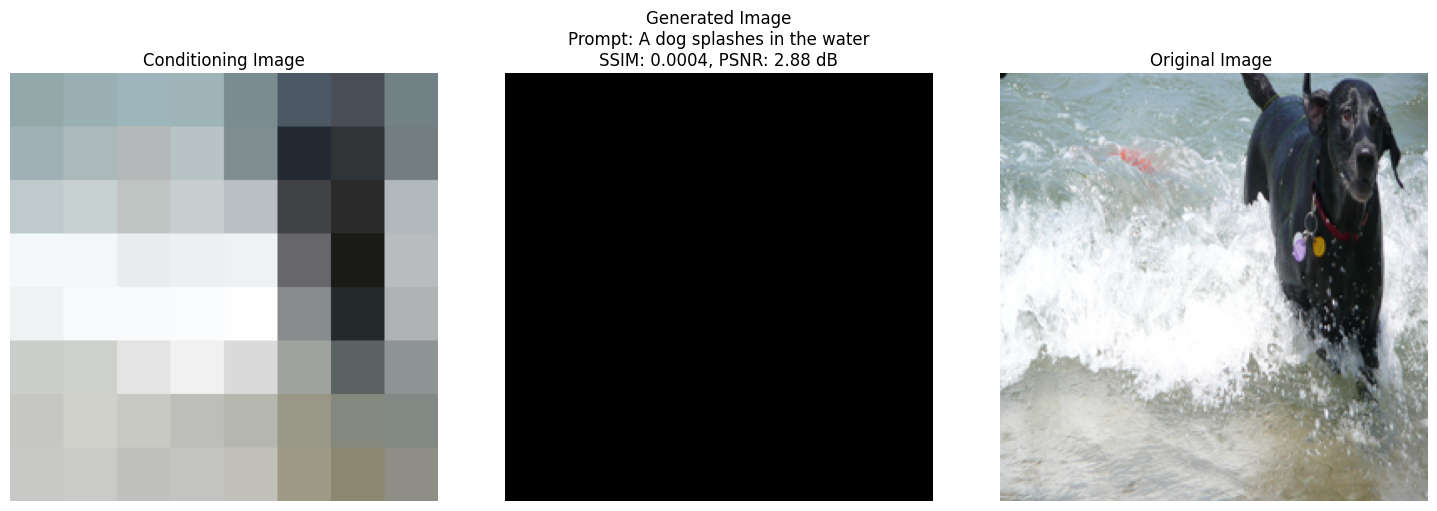

In [24]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

# สุ่มตัวอย่างจาก dataset
idx = random.randint(0, len(dataset)-1)
sample = dataset[idx]

# เรียกข้อมูล
original_image = sample["images"]
conditioning_image = sample["conditioning_images"]
prompt = sample["caption"]

# Generate ภาพจากโมเดล
random_seed = random.randint(0, 100000)
generator = torch.manual_seed(random_seed)
result = pipe(
    prompt=prompt,
    image=conditioning_image,
    generator=generator,
    num_images_per_prompt=1,
    height=256,
    width=256
)
generated_image = result.images[0]

# แปลงภาพเป็น numpy array
original_np = np.array(original_image)
generated_np = np.array(generated_image)

# ตรวจสอบขนาดภาพ
if original_np.shape != generated_np.shape:
    generated_np = np.array(generated_image.resize(original_image.size))

# คำนวณ SSIM และ PSNR (เทียบกับภาพต้นฉบับ)
ssim_score = ssim(original_np, generated_np, channel_axis=2)
psnr_score = psnr(original_np, generated_np)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(conditioning_image)
axs[0].set_title("Conditioning Image")
axs[0].axis("off")

axs[1].imshow(generated_image)
axs[1].set_title(f"Generated Image\nPrompt: {prompt}\nSSIM: {ssim_score:.4f}, PSNR: {psnr_score:.2f} dB")
axs[1].axis("off")

axs[2].imshow(original_image)
axs[2].set_title("Original Image ")
axs[2].axis("off")

plt.tight_layout()
plt.show()

1. SSIM (Structural Similarity Index)
Range ค่า: ตั้งแต่ -1 ถึง 1

1: ภาพเหมือนกันทุกประการ

0: ไม่มีความสัมพันธ์เชิงโครงสร้าง

-1: ตรงกันข้ามเชิงโครงสร้าง


2. PSNR (Peak Signal-to-Noise Ratio)
หน่วย: เดซิเบล (dB)

มากกว่า 30 dB: ภาพคุณภาพดี มีสัญญาณสูงกว่า noise มาก

20-30 dB: ภาพคุณภาพปานกลาง

น้อยกว่า 20 dB: ภาพคุณภาพต่ำ มี noise สูง



SSIM/PSNR: วัดความคล้ายคลึงเชิงโครงสร้างและ pixel-wise

ภาพเจนที่ "ชัดแต่ไม่ตรงโครงสร้าง" อาจได้คะแนนต่ำกว่า ภาพเบลอที่ "ไม่ชัดแต่โครงสร้างใกล้เคียง"